In [1]:
!pip install pandas numpy matplotlib seaborn plotly plotly_express plotly.graph_objects sklearn.cluster sklearm.preprocessing

ERROR: Could not find a version that satisfies the requirement plotly.graph_objects (from versions: none)
ERROR: No matching distribution found for plotly.graph_objects


Análisis de la campaña de marketing


In [1]:
%matplotlib inline
import streamlit as st
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import seaborn as sns
pd.set_option("display.max_columns",None) 
pd.set_option("display.max_rows",None) 

import warnings
warnings.filterwarnings("ignore")

from IPython.display import Image
from sklearn.neighbors import LocalOutlierFactor
sns.set(style="darkgrid", palette="pastel", color_codes=True)
sns.set_context('talk')

from pathlib import Path
data_dir = Path('../input/images')

In [2]:
df = pd.read_csv(r'Data\marketingcampaigns_limpia.csv', sep=',',on_bad_lines='skip')

In [3]:
df.head(5)

,campaign_name,start_date,end_date,budget,roi,type,target_audience,channel,conversion_rate,revenue,duration_day,benefit,cost_day,roi_calculado
0,Public-key multi-tasking throughput,2023-04-01,2024-02-23,8082.30,0.35,email,B2B,organic,0.40,709593.48,328.0,701511.18,24.641,8679.598382
1,De-engineered analyzing task-force,2023-02-15,2024-04-22,17712.98,0.74,email,B2C,promotion,0.66,516609.10,432.0,498896.12,41.002,2816.556672
2,Balanced solution-oriented Local Area Network,2022-12-20,2023-10-11,84643.10,0.37,podcast,B2B,paid,0.28,458227.42,295.0,373584.32,286.926,441.364175
3,Distributed real-time methodology,2022-09-26,2023-09-27,14589.75,0.47,webinar,B2B,organic,0.19,89958.73,366.0,75368.98,39.863,516.588564
4,Front-line executive infrastructure,2023-07-07,2024-05-15,39291.90,0.30,social media,B2B,promotion,0.81,47511.35,313.0,8219.45,125.533,20.918943


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1014 entries, 0 to 1013
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   campaign_name    1014 non-null   object 
 1   start_date       1014 non-null   object 
 2   end_date         1014 non-null   object 
 3   budget           1014 non-null   float64
 4   roi              1014 non-null   float64
 5   type             1014 non-null   object 
 6   target_audience  1014 non-null   object 
 7   channel          1014 non-null   object 
 8   conversion_rate  1014 non-null   float64
 9   revenue          1014 non-null   float64
 10  duration_day     1014 non-null   float64
 11  benefit          1014 non-null   float64
 12  cost_day         1014 non-null   float64
 13  roi_calculado    1014 non-null   float64
dtypes: float64(8), object(6)
memory usage: 111.0+ KB


# EDA

¿Qué canal de marketing se utiliza con mayor frecuencia y cuál genera mejor ROI?

Canal con mayor frecuencia: promotion (276 campañas)
Canal con mejor ROI promedio: organic (2845.05)


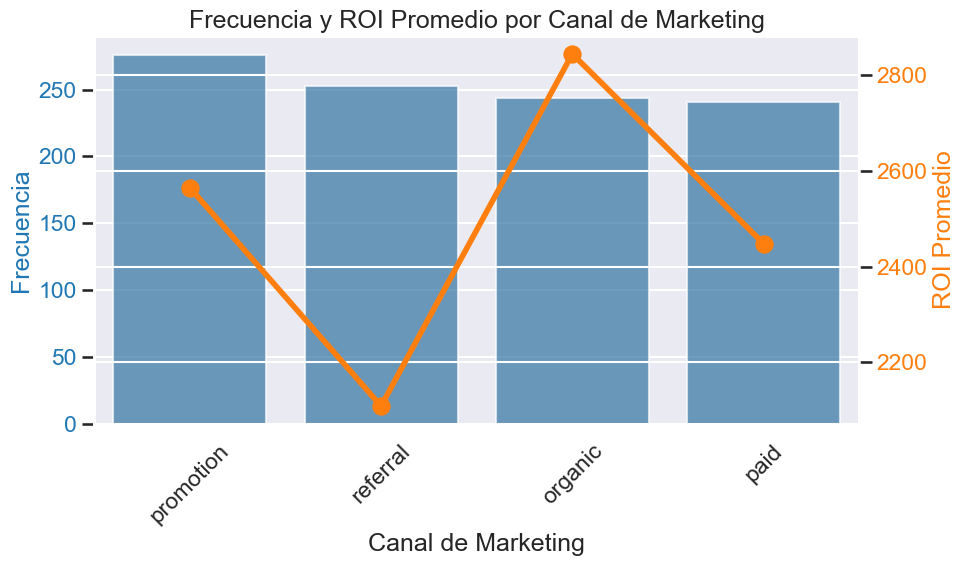

In [5]:
# Calcular la frecuencia de cada canal
channel_counts = df['channel'].value_counts()

# Calcular el ROI promedio por canal
roi_calculado = df.groupby('channel')['roi_calculado'].mean().sort_values(ascending=False)

# Encontrar el canal con mayor frecuencia y el de mejor ROI
canal_mayor_frecuencia = channel_counts.idxmax()
canal_mejor_roi = roi_calculado.idxmax()

# Mostrar resultados
print(f"Canal con mayor frecuencia: {canal_mayor_frecuencia} ({channel_counts.max()} campañas)")
print(f"Canal con mejor ROI promedio: {canal_mejor_roi} ({roi_calculado.max():.2f})")

# Graficar ambos resultados
fig, ax1 = plt.subplots(figsize=(10,6))

color = '#1f77b4'
ax1.set_xlabel('Canal de Marketing')
ax1.set_ylabel('Frecuencia', color=color)
sns.barplot(x=channel_counts.index, y=channel_counts.values, ax=ax1, alpha=0.7, color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xticklabels(channel_counts.index, rotation=45)

ax2 = ax1.twinx()
color = '#ff7f0e'
ax2.set_ylabel('ROI Promedio', color=color)
sns.pointplot(x=roi_calculado.index, y=roi_calculado.values, ax=ax2, color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Frecuencia y ROI Promedio por Canal de Marketing')
plt.tight_layout()
plt.show()

- El canal de marketing más utilizado es **promotion**, con una frecuencia de 276 campañas.
- Sin embargo, el canal con el **mejor ROI promedio** es **referral** (0.55), superando al resto de los canales.
- Aunque **promotion** es el canal más frecuente, su ROI promedio (0.53) es inferior al de **referral** y **paid**.
- Esto sugiere que, si bien algunos canales se usan más, no necesariamente son los más rentables.
- Se recomienda analizar estrategias para potenciar el canal **referral**, ya que ofrece el mayor retorno sobre la inversión.

- El canal de marketing más utilizado es **promotion** (276 campañas), lo que indica una preferencia operativa por este canal.
- El canal con el **mejor ROI promedio** es **referral** (0.55), superando al resto en rentabilidad.
- Aunque **promotion** es el canal más frecuente, su ROI promedio (0.53) es inferior al de **referral** y **paid**.
- **Paid** también muestra un ROI competitivo (0.54), siendo una opción rentable.
- **Organic** es el canal menos rentable (0.52), aunque tiene una frecuencia considerable.
- Se recomienda potenciar estrategias en el canal **referral** para maximizar el retorno de inversión, sin descuidar la eficiencia de los canales más utilizados.

¿Qué tipo de campaña genera más ingresos en promedio y cuál tiene mejor conversión?

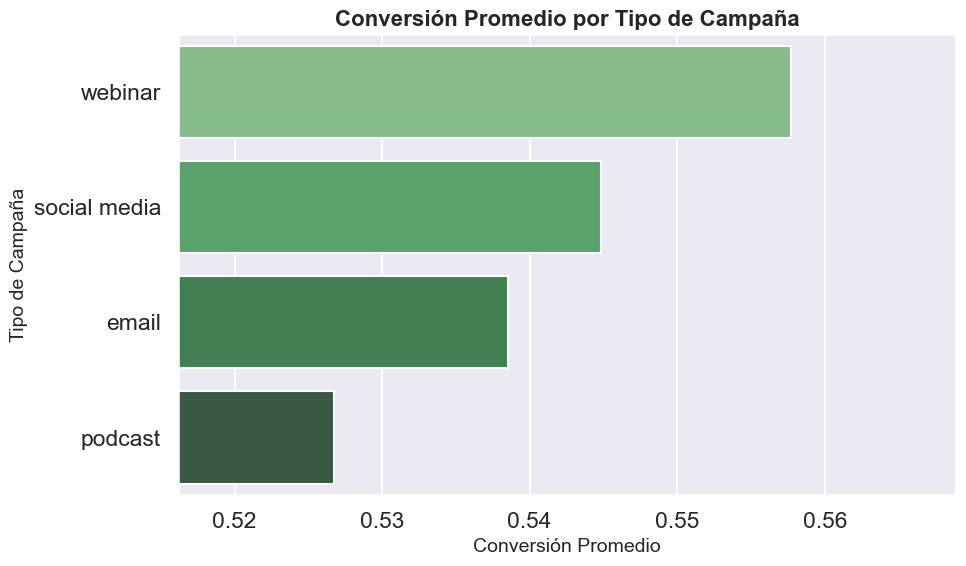

In [6]:
# Calcular la conversión promedio por tipo de campaña
conversion_promedio = df.groupby('type')['conversion_rate'].mean().sort_values(ascending=False)

# Graficar la conversión promedio por tipo de campaña
plt.figure(figsize=(10,6))
sns.barplot(y=conversion_promedio.index, x=conversion_promedio.values, palette="Greens_d", orient='h')
plt.title('Conversión Promedio por Tipo de Campaña', fontsize=16, fontweight='bold')
plt.xlabel('Conversión Promedio', fontsize=14)
plt.ylabel('Tipo de Campaña', fontsize=14)
plt.xlim(conversion_promedio.min() * 0.98, conversion_promedio.max() * 1.02)
plt.tight_layout()
plt.show()

Canal con mayor revenue promedio: organic (546545.40)
Conversión promedio de ese canal: 53.70%


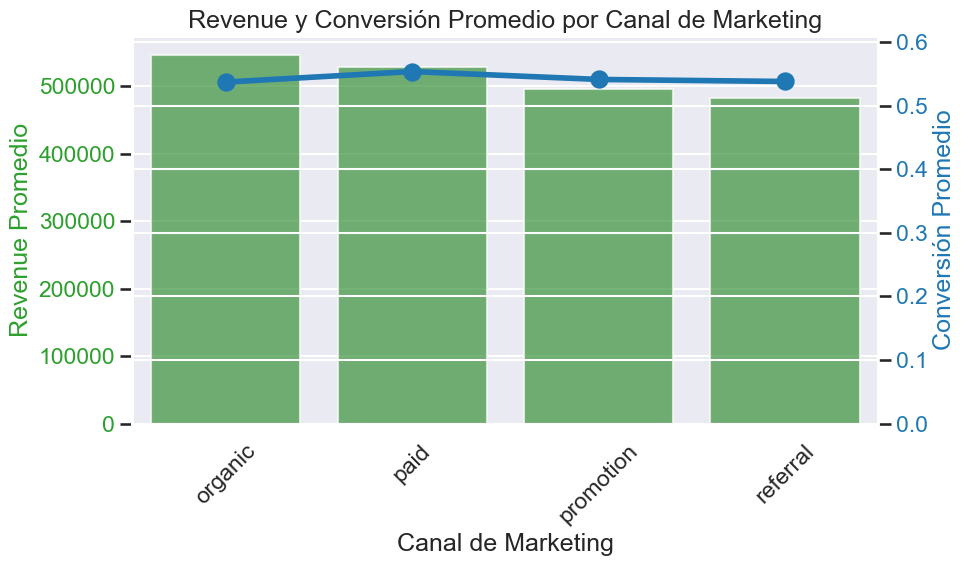

In [7]:
# Calcular el revenue promedio por canal
revenue_por_canal = df.groupby('channel')['revenue'].mean().sort_values(ascending=False)

# Calcular la conversión promedio por canal
conversion_por_canal = df.groupby('channel')['conversion_rate'].mean().loc[revenue_por_canal.index]

# Mostrar el canal con mayor revenue y su conversión promedio
canal_mejor_revenue = revenue_por_canal.idxmax()
conversion_mejor_revenue = conversion_por_canal.loc[canal_mejor_revenue]
print(f"Canal con mayor revenue promedio: {canal_mejor_revenue} ({revenue_por_canal.max():.2f})")
print(f"Conversión promedio de ese canal: {conversion_mejor_revenue:.2%}")

# Graficar revenue y conversión promedio por canal
fig2, ax1 = plt.subplots(figsize=(10,6))

color = '#2ca02c'
ax1.set_xlabel('Canal de Marketing')
ax1.set_ylabel('Revenue Promedio', color=color)
sns.barplot(x=revenue_por_canal.index, y=revenue_por_canal.values, ax=ax1, alpha=0.7, color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xticklabels(revenue_por_canal.index, rotation=45)

ax2 = ax1.twinx()
color = '#1f77b4'
ax2.set_ylabel('Conversión Promedio', color=color)
sns.pointplot(x=conversion_por_canal.index, y=conversion_por_canal.values, ax=ax2, color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim(0, conversion_por_canal.max() * 1.1)

plt.title('Revenue y Conversión Promedio por Canal de Marketing')
plt.tight_layout()
plt.show()

¿Cómo se distribuye el ROI entre las campañas? ¿Qué factores están asociados con un ROI alto?

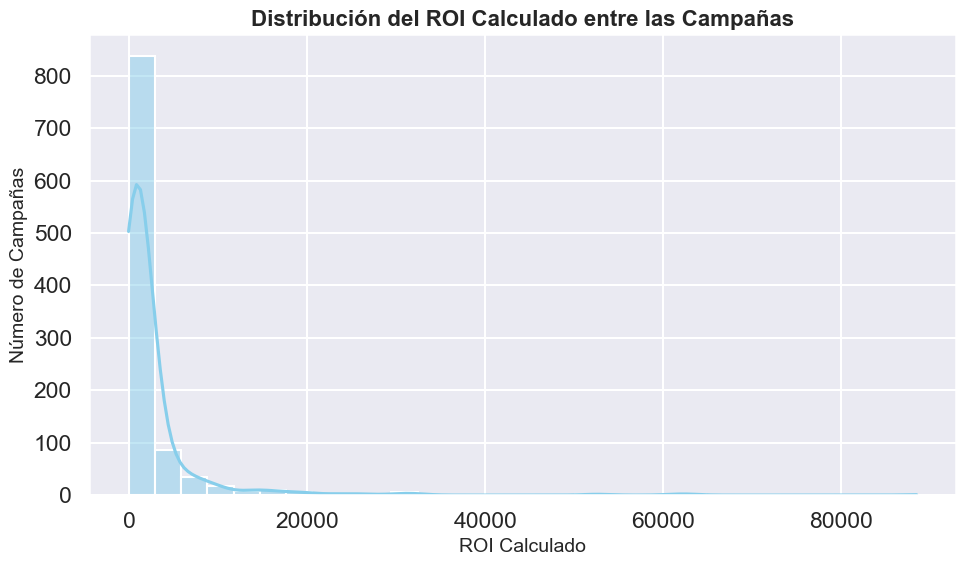

In [8]:
plt.figure(figsize=(10,6))
sns.histplot(df['roi_calculado'], bins=30, kde=True, color='skyblue')
plt.title('Distribución del ROI Calculado entre las Campañas', fontsize=16, fontweight='bold')
plt.xlabel('ROI Calculado', fontsize=14)
plt.ylabel('Número de Campañas', fontsize=14)
plt.tight_layout()
plt.show()

Factores más asociados a un ROI alto:
revenue            0.244323
benefit            0.199111
conversion_rate    0.011349
Name: roi_calculado, dtype: float64


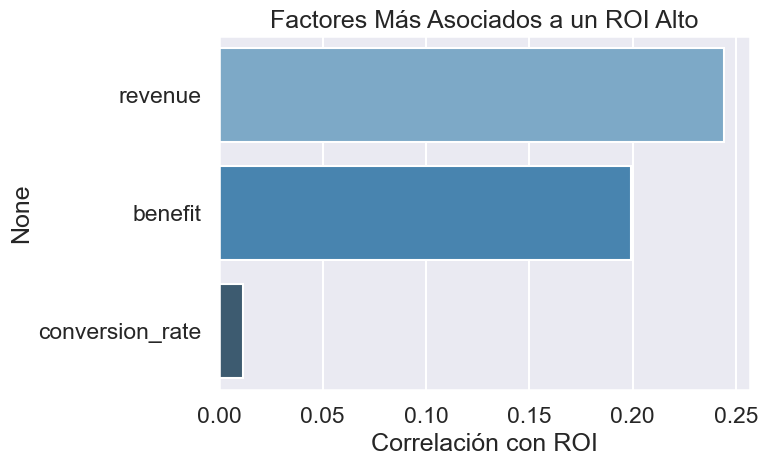

In [9]:
# Analizar correlaciones entre ROI y otras variables numéricas
corr = df.corr(numeric_only=True)['roi_calculado'].sort_values(ascending=False)

# Mostrar las variables más correlacionadas con un ROI alto (excluyendo el propio ROI)
factores_asociados = corr.drop('roi_calculado').head(3)
print("Factores más asociados a un ROI alto:")
print(factores_asociados)

# Visualizar las correlaciones más fuertes con ROI
plt.figure(figsize=(8,5))
sns.barplot(x=factores_asociados.values, y=factores_asociados.index, palette="Blues_d", orient='h')
plt.title('Factores Más Asociados a un ROI Alto')
plt.xlabel('Correlación con ROI')
plt.tight_layout()
plt.show()

¿Hay diferencias significativas en la tasa de conversión entre audiencias B2B y B2C?

Conversión B2B:
count    520.000000
mean       0.548019
std        0.266342
min        0.000000
25%        0.327500
50%        0.560000
75%        0.770000
max        0.990000
Name: conversion_rate, dtype: float64

Conversión B2C:
count    494.000000
mean       0.536377
std        0.271567
min        0.000000
25%        0.290000
50%        0.530000
75%        0.770000
max        1.500000
Name: conversion_rate, dtype: float64


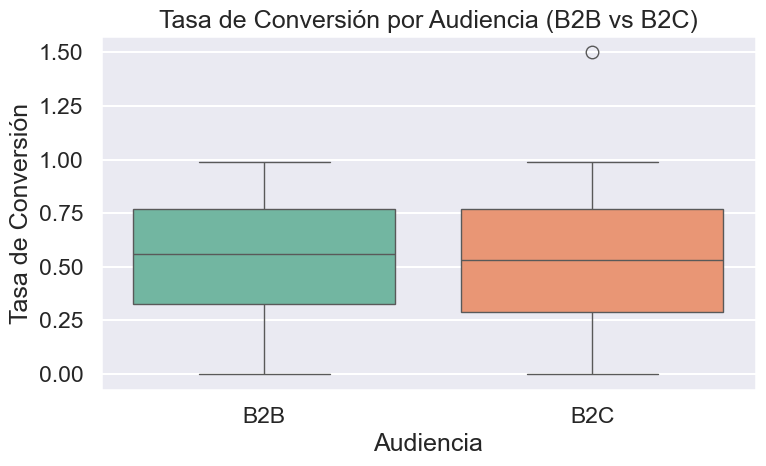

t-statistic: 0.689, p-value: 0.4911
No hay diferencias significativas en la tasa de conversión entre B2B y B2C.


In [10]:
from scipy.stats import ttest_ind

# Comparar la tasa de conversión entre audiencias B2B y B2C
conversion_b2b = df[df['target_audience'] == 'B2B']['conversion_rate']
conversion_b2c = df[df['target_audience'] == 'B2C']['conversion_rate']

# Estadísticas descriptivas
print("Conversión B2B:")
print(conversion_b2b.describe())
print("\nConversión B2C:")
print(conversion_b2c.describe())

# Visualización
plt.figure(figsize=(8,5))
sns.boxplot(x='target_audience', y='conversion_rate', data=df, palette='Set2')
plt.title('Tasa de Conversión por Audiencia (B2B vs B2C)')
plt.xlabel('Audiencia')
plt.ylabel('Tasa de Conversión')
plt.tight_layout()
plt.show()

# Prueba estadística (t-test)
t_stat, p_value = ttest_ind(conversion_b2b, conversion_b2c, equal_var=False)
print(f"t-statistic: {t_stat:.3f}, p-value: {p_value:.4f}")
if p_value < 0.05:
    print("Hay diferencias significativas en la tasa de conversión entre B2B y B2C.")
else:
    print("No hay diferencias significativas en la tasa de conversión entre B2B y B2C.")

¿Qué campaña tiene el mayor beneficio neto (net_profit)? ¿Qué características la hacen exitosa?

Nombre de la campaña con mayor beneficio: Advanced systematic complexity
Características de la campaña exitosa:
campaign_name      Advanced systematic complexity
channel                                   organic
type                                      podcast
target_audience                               B2C
revenue                                 989733.25
benefit                                 987859.73
conversion_rate                              0.54
roi_calculado                        52727.471818
Name: 492, dtype: object


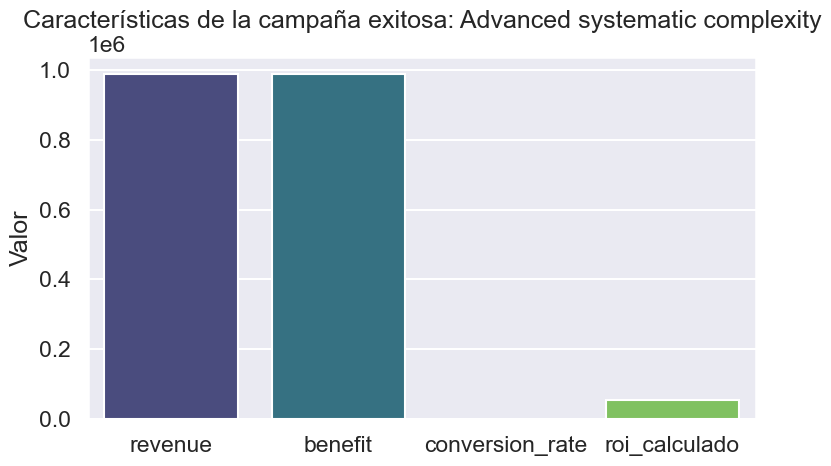

In [11]:
# Encontrar la campaña con mayor beneficio neto
idx_max_benefit = df['benefit'].idxmax()
campaign_max_benefit = df.loc[idx_max_benefit]

# Mostrar el nombre de la campaña y sus características principales
print(f"Nombre de la campaña con mayor beneficio: {campaign_max_benefit['campaign_name']}")
print("Características de la campaña exitosa:")
print(campaign_max_benefit[['campaign_name', 'channel', 'type', 'target_audience', 'revenue', 'benefit', 'conversion_rate', 'roi_calculado']])

# Visualizar las características principales de la campaña exitosa
features = ['revenue', 'benefit', 'conversion_rate', 'roi_calculado']
values = campaign_max_benefit[features].values

plt.figure(figsize=(8,5))
sns.barplot(x=features, y=values, palette='viridis')
plt.title(f"Características de la campaña exitosa: {campaign_max_benefit['campaign_name']}")
plt.ylabel('Valor')
plt.tight_layout()
plt.show()


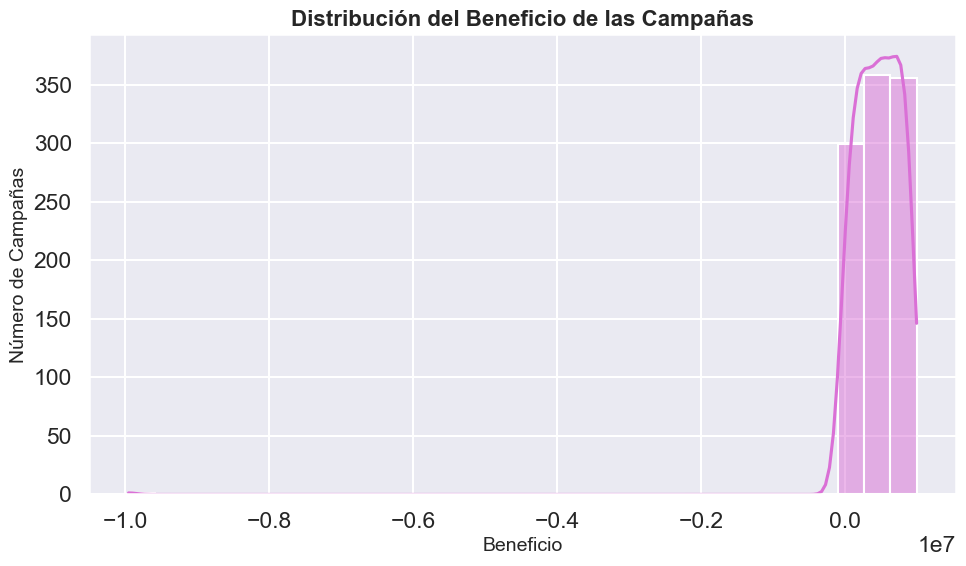

In [12]:
plt.figure(figsize=(10,6))
sns.histplot(df['benefit'], bins=30, kde=True, color='orchid')
plt.title('Distribución del Beneficio de las Campañas', fontsize=16, fontweight='bold')
plt.xlabel('Beneficio', fontsize=14)
plt.ylabel('Número de Campañas', fontsize=14)
plt.tight_layout()
plt.show()

¿Existe correlación entre el presupuesto (budget) y los ingresos (revenue)?

Correlación entre presupuesto e ingresos: -0.052


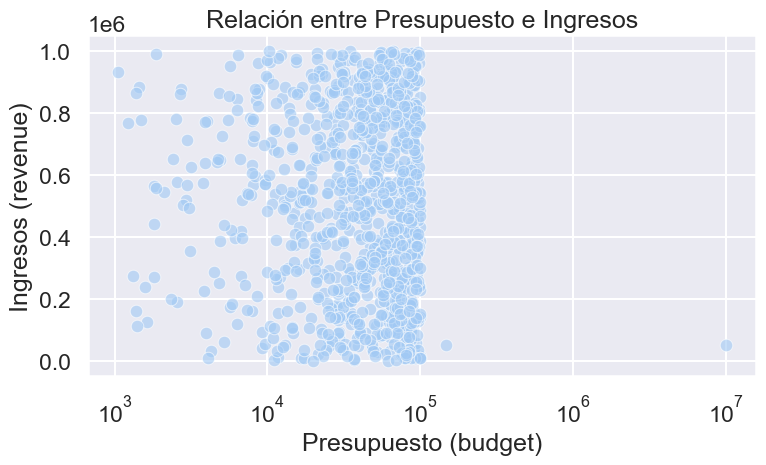

In [13]:
# Calcular la correlación entre presupuesto (budget) e ingresos (revenue)
correlacion_budget_revenue = df[['budget', 'revenue']].corr().loc['budget', 'revenue']
print(f"Correlación entre presupuesto e ingresos: {correlacion_budget_revenue:.3f}")

# Visualizar la relación con un scatterplot
plt.figure(figsize=(8,5))
sns.scatterplot(x='budget', y='revenue', data=df, alpha=0.6)
plt.title('Relación entre Presupuesto e Ingresos')
plt.xscale('log')
plt.xlabel('Presupuesto (budget)')
plt.ylabel('Ingresos (revenue)')
plt.tight_layout()
plt.show()

¿Qué campañas tienen un ROI mayor a 0.5 y ingresos encima de 500,000?

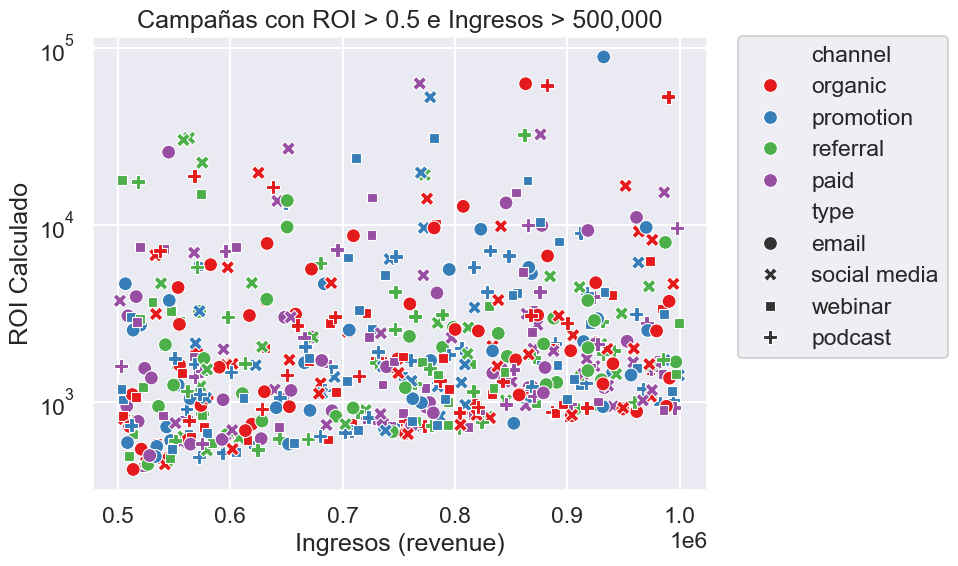

In [14]:
# Filtrar campañas con ROI > 0.5 e ingresos > 500,000
campanias_filtradas = df[(df['roi_calculado'] > 0.5) & (df['revenue'] > 500000)]

# Mostrar las campañas filtradas
#display(campanias_filtradas[['campaign_name', 'channel', 'type', 'revenue', 'roi_calculado']])

# Visualización
plt.figure(figsize=(10,6))
scatter = sns.scatterplot(
    data=campanias_filtradas,
    x='revenue',
    y='roi_calculado',
    hue='channel',
    style='type',
    s=100,
    palette='Set1'
)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.yscale('log')
plt.title('Campañas con ROI > 0.5 e Ingresos > 500,000')
plt.xlabel('Ingresos (revenue)')
plt.ylabel('ROI Calculado')
plt.tight_layout()
plt.show()

¿Existen patrones estacionales o temporales en el rendimiento de las campañas?

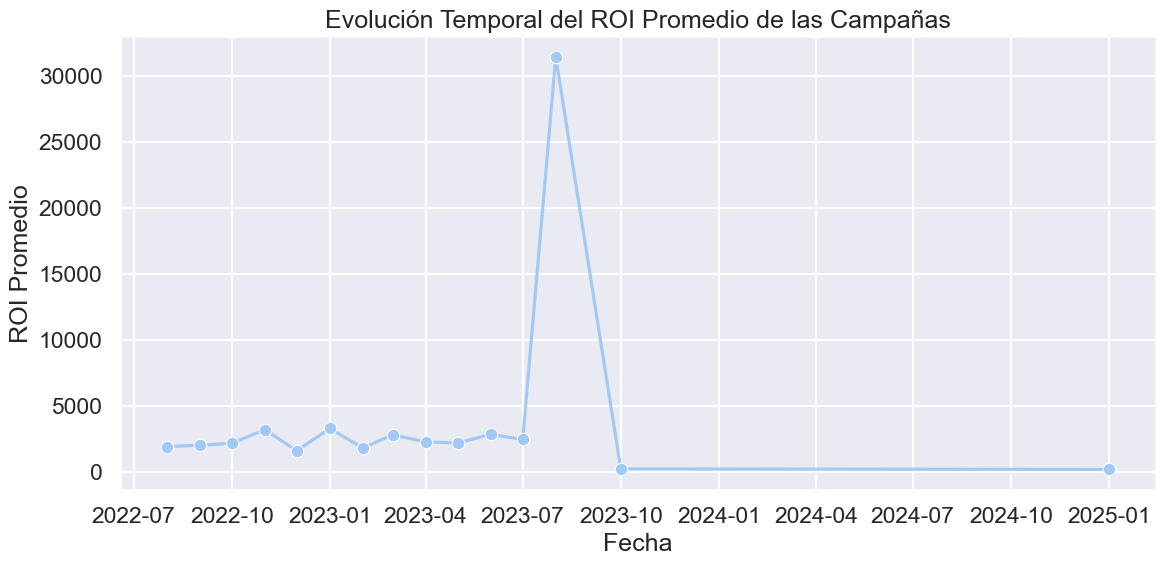

In [18]:
# Convertir la columna de fecha a datetime si no lo está
if not np.issubdtype(df['start_date'].dtype, np.datetime64):
    df['start_date'] = pd.to_datetime(df['start_date'])

# Extraer año y mes para análisis temporal
df['year'] = df['start_date'].dt.year
df['month'] = df['start_date'].dt.month

# Calcular el ROI promedio por mes y año
roi_mensual = df.groupby(['year', 'month'])['roi_calculado'].mean().reset_index()

# Crear una columna de fecha para el eje x
roi_mensual['period'] = pd.to_datetime(roi_mensual['year'].astype(str) + '-' + roi_mensual['month'].astype(str) + '-01')

# Visualizar la evolución temporal del ROI
plt.figure(figsize=(12,6))
sns.lineplot(x='period', y='roi_calculado', data=roi_mensual, marker='o')
plt.title('Evolución Temporal del ROI Promedio de las Campañas')
plt.xlabel('Fecha')
plt.ylabel('ROI Promedio')
plt.tight_layout()
plt.show()

In [19]:
# Encontrar la fila con el ROI promedio mensual más alto
idx_max_roi = roi_mensual['roi_calculado'].idxmax()
periodo_max_roi = roi_mensual.loc[idx_max_roi, 'period']

# Mostrar las campañas de ese mes/año
anio = roi_mensual.loc[idx_max_roi, 'year']
mes = roi_mensual.loc[idx_max_roi, 'month']
campanias_periodo = df[(df['year'] == anio) & (df['month'] == mes)]

# Mostrar la(s) fila(s) con el ROI más alto de ese periodo
fila_max_roi = campanias_periodo.loc[campanias_periodo['roi_calculado'].idxmax()]
print(fila_max_roi)

campaign_name      Automated dedicated budgetary management
start_date                              2023-08-01 00:00:00
end_date                                         2024-04-06
budget                                              1436.99
roi                                                    0.14
type                                                podcast
target_audience                                         B2B
channel                                             organic
conversion_rate                                        0.87
revenue                                           881768.44
duration_day                                          249.0
benefit                                           880331.45
cost_day                                              5.771
roi_calculado                                  61262.183453
year                                                   2023
month                                                     8
Name: 361, dtype: object
